# **1. Lectura de paquetes y data**


In [56]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, ARIMA
from itertools import product
import matplotlib.pyplot as plt
import warnings

import os

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
warnings.filterwarnings("ignore")

Utilizamos paths relativos para la lectura de la data

In [57]:
filename = "Evaluacion_modelos_st.ipynb"  # nombre del archivo actual
print(f"Current absolute path: {os.getcwd()}\n")

# Especificamos la ruta del directorio actual y los directorios de datos y salida
ACTUAL_DIR = os.path.dirname(os.path.abspath(filename))
BASE_DIR = os.path.dirname(ACTUAL_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data")
OUTPUT_DIR = os.path.join(DATA_DIR, "output")

print(f"BASE_DIR: {BASE_DIR}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")

Current absolute path: c:\Users\jhona\Dropbox\ASPECTOS MAESTRIA\Cursos semestres\SEMESTRE 1\Proyecto 1 - Innovacion tecnologica en IA\innv_tec_1_icesi\notebooks

BASE_DIR: c:\Users\jhona\Dropbox\ASPECTOS MAESTRIA\Cursos semestres\SEMESTRE 1\Proyecto 1 - Innovacion tecnologica en IA\innv_tec_1_icesi
DATA_DIR: c:\Users\jhona\Dropbox\ASPECTOS MAESTRIA\Cursos semestres\SEMESTRE 1\Proyecto 1 - Innovacion tecnologica en IA\innv_tec_1_icesi\data
OUTPUT_DIR: c:\Users\jhona\Dropbox\ASPECTOS MAESTRIA\Cursos semestres\SEMESTRE 1\Proyecto 1 - Innovacion tecnologica en IA\innv_tec_1_icesi\data\output


In [58]:
# Cargar el archivo de Excel
file_path = os.path.join(DATA_DIR, "data_demanda.xlsx")
df_base = pd.read_excel(file_path, sheet_name="data")
df_base = df_base.drop("Cliente", axis=1)

In [59]:
df_base

,Fe.prefer.entrega,Day_of_the_Week,Pedidos,Sell_In,Sell_in_on_time,CEDIS,SKU,Mes_Año,Sell_in_rezago,porcentaje_on_time,Subcategoria
0,2024-07-01,Monday,7800,7800,7800,4,SKU7,72024,0,1.000000,BEBIDAS DE YOGUR
1,2024-07-01,Monday,10200,10260,10200,6,SKU5,72024,60,1.000000,BEBIDAS DE YOGUR
2,2024-07-01,Monday,3060,3060,3060,6,SKU6,72024,0,1.000000,BEBIDAS DE YOGUR
3,2024-07-01,Monday,3450,3450,3450,7,SKU4,72024,0,1.000000,BEBIDAS DE YOGUR
4,2024-07-01,Monday,8400,8400,8400,5,SKU3,72024,0,1.000000,BEBIDAS DE YOGUR
...,...,...,...,...,...,...,...,...,...,...,...
7046,2025-04-15,Tuesday,300,300,300,1,SKU9,42025,0,1.000000,KUMIS
7047,2025-04-15,Tuesday,18000,15000,15000,3,SKU17,42025,0,0.833333,LECHE SABORIZADA
7048,2025-04-15,Tuesday,3480,2124,2124,3,SKU14,42025,0,0.610345,FIOCOSSOS
7049,2025-04-15,Tuesday,3150,3150,3150,2,SKU16,42025,0,1.000000,LECHE PASTEURIZADA


In [60]:
# Filtrar los datos relevantes para este analisis

df = (
    df_base[["Fe.prefer.entrega", "SKU", "Pedidos"]]
    .copy()
    .rename(
        columns={
            "Fe.prefer.entrega": "Fecha",
        }
    )
)
df["Pedidos"] = pd.to_numeric(df["Pedidos"], errors="coerce")

In [61]:
df

,Fecha,SKU,Pedidos
0,2024-07-01,SKU7,7800
1,2024-07-01,SKU5,10200
2,2024-07-01,SKU6,3060
3,2024-07-01,SKU4,3450
4,2024-07-01,SKU3,8400
...,...,...,...
7046,2025-04-15,SKU9,300
7047,2025-04-15,SKU17,18000
7048,2025-04-15,SKU14,3480
7049,2025-04-15,SKU16,3150


In [62]:
### Primero, nos aseguramos de que se cuente un dato por SKU por dia
# -------

# rango completo de fechas desde la más antigua hasta la más reciente
fecha_min = df["Fecha"].min()
fecha_max = df["Fecha"].max()
rango_fechas = pd.date_range(start=fecha_min, end=fecha_max, freq="D")

# Obtenemos todos los SKUs únicos
skus = df["SKU"].unique()

# DataFrame con todas las combinaciones de SKU y fecha
combinaciones_completas = pd.MultiIndex.from_product(
    [rango_fechas, skus], names=["Fecha", "SKU"]
).to_frame(index=False)

# Unir con el dataframe original para rellenar con ceros donde falten datos
df_completo = combinaciones_completas.merge(df, on=["Fecha", "SKU"], how="left")

# Rellenar valores faltantes de pedidos con 0
df_completo["Pedidos"] = df_completo["Pedidos"].fillna(0).astype(int)

# Ordenar por SKU y Fecha (opcional)
df_completo = df_completo.sort_values(["SKU", "Fecha"]).reset_index(drop=True)

df = df_completo.copy()

In [63]:
df

,Fecha,SKU,Pedidos
0,2024-07-01,SKU1,0
1,2024-07-02,SKU1,0
2,2024-07-03,SKU1,43200
3,2024-07-04,SKU1,30000
4,2024-07-05,SKU1,7200
...,...,...,...
7509,2025-04-11,SKU9,1200
7510,2025-04-12,SKU9,600
7511,2025-04-13,SKU9,420
7512,2025-04-14,SKU9,1200


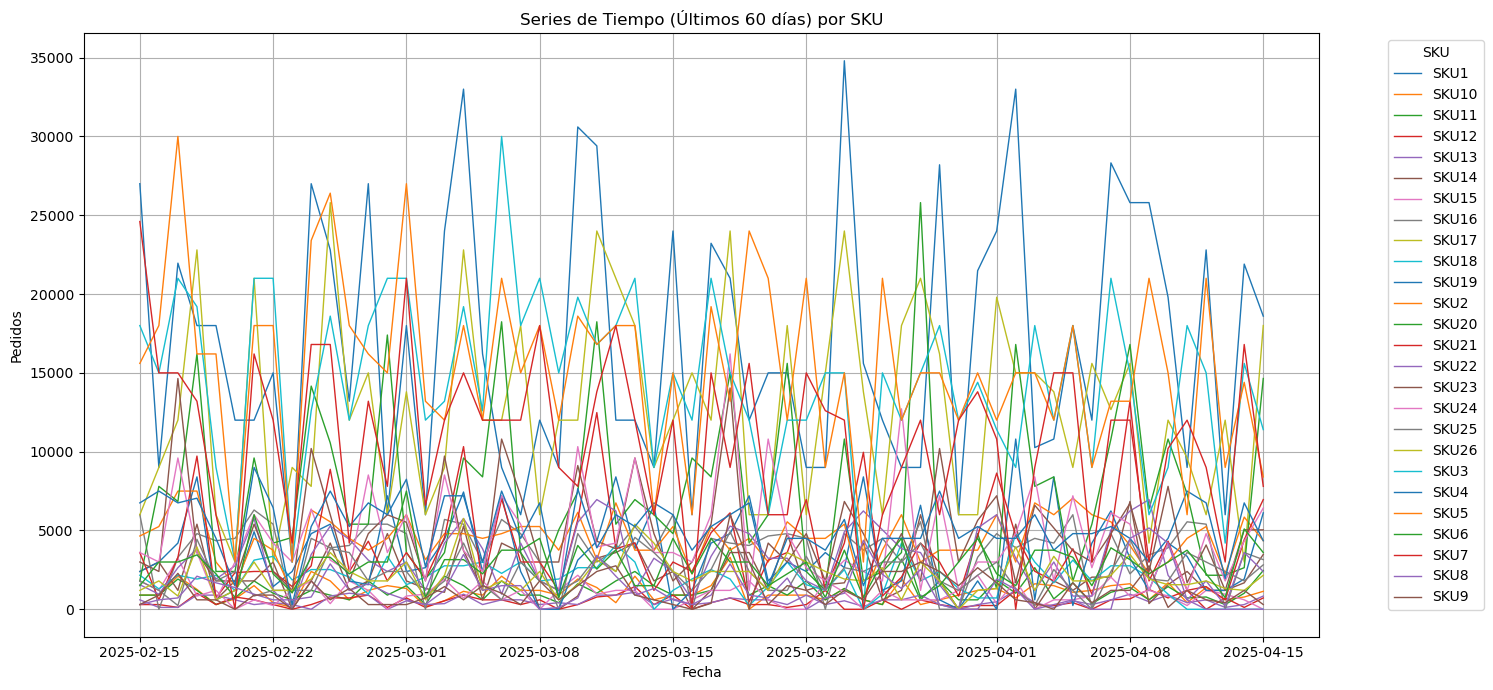

In [64]:
### Grafico de series de tiempo para todos los SKU (ultimos 60 dias)
# ----

# Calcular la fecha límite: últimos 60 días desde la fecha máxima
fecha_max = df["Fecha"].max()
fecha_min = fecha_max - pd.Timedelta(days=59)

# Filtrar el DataFrame a los últimos 60 días
df_ultimos_60 = df[df["Fecha"].between(fecha_min, fecha_max)]

plt.figure(figsize=(15, 7))

# Graficar cada serie de tiempo por SKU
for sku in df_ultimos_60["SKU"].unique():
    datos_sku = df_ultimos_60[df_ultimos_60["SKU"] == sku]
    plt.plot(datos_sku["Fecha"], datos_sku["Pedidos"], label=sku, linewidth=1)

# Títulos y etiquetas
plt.title("Series de Tiempo (Últimos 60 días) por SKU")
plt.xlabel("Fecha")
plt.ylabel("Pedidos")
plt.legend(
    title="SKU", bbox_to_anchor=(1.05, 1), loc="upper left"
)  # Mueve la leyenda fuera del gráfico
plt.tight_layout()
plt.grid(True)

# Mostrar la gráfica
plt.show()

# 1. Identificación de tipo de demanda

 A continuación, clasificaremos la demanda de productos (SKU) según su variabilidad (CoV) y frecuencia (INT o ADI), y asignarles una categoría basada en estas métricas para futuros modelos a evaluar.

In [65]:
# Función para calcular CoV e Intermitencia (ADI)
def classify_demand(group):
    demand_series = group["Pedidos"].fillna(0)
    total_periods = len(demand_series)
    non_zero_periods = (demand_series > 0).sum()

    # Coeficiente de variación (CoV)
    mean = demand_series.mean()
    std = demand_series.std()
    cov = (std / mean) * 100 if mean > 0 else np.nan

    # Intermitencia (ADI)
    adi = total_periods / non_zero_periods if non_zero_periods > 0 else np.nan

    return pd.Series(
        {
            "CoV": cov,
            "INT": adi,
            "Periods": total_periods,
            "NonZeroPeriods": non_zero_periods,
        }
    )


# Agrupar por SKU
demand_classification = df.groupby("SKU").apply(classify_demand).reset_index()

In [66]:
# Clasificación CoV
def classify_cov(cov):
    if pd.isna(cov):
        return 5
    elif cov > 33.3:
        return 1
    elif 20.8 < cov <= 33.3:
        return 2
    elif 8.3 < cov <= 20.8:
        return 3
    elif 0 <= cov <= 8.3:
        return 4
    else:
        return 5


# Clasificación INT
def classify_int(adi):
    if pd.isna(adi):
        return 5
    elif adi > 1.32:
        return 1  # Alta intermitencia
    elif 1.1 < adi <= 1.32:
        return 2  # Moderada intermitencia
    elif 1.0 < adi <= 1.1:
        return 3  # Casi continua
    elif adi == 1.0:
        return 4  # Completamente continua
    else:
        return 5


# Aplicar puntajes
demand_classification["CoV_Score"] = demand_classification["CoV"].apply(classify_cov)
demand_classification["INT_Score"] = demand_classification["INT"].apply(classify_int)
demand_classification["Total_Score"] = (
    demand_classification["CoV_Score"] + demand_classification["INT_Score"]
)

In [67]:
def demand_category(score):
    if score <= 2:
        return "Erratic"
    elif score <= 4:
        return "Irregular"
    elif score <= 6:
        return "Uneven"
    elif score <= 8:
        return "Smooth"
    else:
        return "No Demand"


demand_classification["Classification"] = demand_classification["Total_Score"].apply(
    demand_category
)

In [68]:
# Mostrar resultados ordenados por SKU
demand_classification.sort_values(by="SKU").head(100)

,SKU,CoV,INT,Periods,NonZeroPeriods,CoV_Score,INT_Score,Total_Score,Classification
0,SKU1,90.772567,1.146825,289.0,252.0,1,2,3,Irregular
1,SKU10,57.476080,1.043321,289.0,277.0,1,3,4,Irregular
2,SKU11,60.714169,1.043321,289.0,277.0,1,3,4,Irregular
3,SKU12,73.767369,1.120155,289.0,258.0,1,2,3,Irregular
4,SKU13,69.651138,1.124514,289.0,257.0,1,2,3,Irregular
5,SKU14,84.661108,1.082397,289.0,267.0,1,3,4,Irregular
6,SKU15,83.295895,1.199170,289.0,241.0,1,2,3,Irregular
7,SKU16,49.143756,1.165323,289.0,248.0,1,2,3,Irregular
8,SKU17,73.972885,1.086466,289.0,266.0,1,3,4,Irregular
9,SKU18,55.904065,1.058608,289.0,273.0,1,3,4,Irregular


# **2. Selección de Modelos de Series de Tiempo**

A partir de la clasificación que le asignamos a cada SKU, elegiremos un set de modelos a implementar por cada tipo de demanda.


| **Clasificación** | **Modelos sugeridos (Model Set)**                                                       | **Notas clave**                             |
| ----------------- | --------------------------------------------------------------------------------------- | ------------------------------------------- |
| **Smooth**        | Exponential Smoothing, Moving Average                                                   | Baja variabilidad, no hay tendencia marcada |
| **Uneven**        | Holt-Winters (Additive o Multiplicative), ARIMA, Double Exponential                     | Variabilidad moderada, posibles patrones    |
| **Irregular**     | ARIMA, Stepwise ARIMA, Holt-Winters, Double Exponential                                 | Tendencias leves, más ruido                 |
| **Erratic**       | Croston’s, Intermittent Demand Methods (TSB, SBA si se quiere extender), Moving Average | Demanda muy esporádica                      |
| **No Demand**     | No se modela (forecast = 0 o revisión manual)                                           | No aplica modelo estadístico                |


Flujo a implementar por cada SKU:

1. Usar la clasificación calculada.

2. Asignar el conjunto de modelos correspondiente.

3. Simular cada modelo del conjunto.

4. Calcular errores (ej. MAE, RMSE, MAPE).

5. Seleccionar el Best Fit (modelo con menor error).

6. Guardar el forecast.

In [69]:
# Función para asignar model set:


def assign_model_set(classification):
    if classification == "Smooth":
        return ["exp_smoothing", "moving_average"]
    elif classification == "Uneven":
        return ["holt_winters", "holt_winters_additive", "arima", "double_exp"]
    elif classification == "Irregular":
        return ["arima", "stepwise_arima", "holt_winters", "double_exp"]
    elif classification == "Erratic":
        return ["croston", "moving_average"]
    else:
        return []


demand_classification["Model_Set"] = demand_classification["Classification"].apply(
    assign_model_set
)

# **3. Corrección de Outliers**

Con el objetivo de evitar valores puntuales considerados como outliers con potencial de afectar el entrenamiento o proyección, se realiza una corrección **POR SKU**

In [70]:
# Corregir outliers por SKU
def correct_outliers(group):
    series = group["Pedidos"].copy()
    mean = series.mean()
    std = series.std()
    lower = mean - 2 * std
    upper = mean + 2 * std
    series = series.apply(lambda x: lower if x < lower else upper if x > upper else x)
    group["Pedidos_Clean"] = series
    return group


df_cleaned = df.groupby("SKU").apply(correct_outliers).reset_index(drop=True)

In [71]:
df_cleaned[["Pedidos", "Pedidos_Clean"]].describe()

,Pedidos,Pedidos_Clean
count,7514.000000,7514.000000
mean,4458.250732,4378.259147
std,6034.549104,5720.734063
min,0.000000,0.000000
25%,840.000000,840.000000
50%,2400.000000,2400.000000
75%,5400.000000,5400.000000
max,84600.000000,44147.835806


# **4. Funciones de evaluación y modelos**

Procedemos a definir funciones para evaluar modelos de series de tiempo, específicamente los modelos Holt-Winters (suavizamiento exponencial) y ARIMA, aplicando una búsqueda en rejilla (grid search) sobre distintos parámetros. 

El objetivo es encontrar la configuración con mejor desempeño, evaluada mediante métricas como MAE, RMSE y MAPE.

In [72]:
# Calcula el error porcentual absoluto medio (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Evita división por cero: solo considera valores donde y_true ≠ 0
    non_zero = y_true != 0

    # Calcula el MAPE sobre esos valores
    return (
        np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100
    )


# Divide una serie en entrenamiento y prueba
def split_series(series, test_size=7):
    return series[:-test_size], series[-test_size:]


# Evalúa múltiples configuraciones del modelo Holt-Winters y devuelve la mejor
def evaluate_holt_winters(train, test, seasonal_periods=7):
    best_result = None  # Para almacenar el mejor resultado

    # Prueba distintas combinaciones de tendencia y estacionalidad
    for trend in [None, "add", "mul"]:
        for seasonal in [None, "add", "mul"]:

            # Prueba combinaciones de parámetros de suavizamiento (alpha, beta, gamma)
            for alpha, beta, gamma in product([0.2, 0.4, 0.6, 0.8], repeat=3):
                try:
                    # Ajusta el modelo Holt-Winters con los parámetros dados
                    model = ExponentialSmoothing(
                        train,
                        trend=trend,
                        seasonal=seasonal,
                        seasonal_periods=seasonal_periods,
                    ).fit(
                        smoothing_level=alpha,
                        smoothing_slope=beta,
                        smoothing_seasonal=gamma,
                        optimized=False,
                    )

                    # Genera pronóstico para el tamaño del conjunto de prueba
                    forecast = model.forecast(len(test))

                    # Calcula métricas de error
                    mae = mean_absolute_error(test, forecast)
                    rmse = np.sqrt(mean_squared_error(test, forecast))
                    mape = mean_absolute_percentage_error(test, forecast)

                    # Guarda configuración del modelo
                    config = f"HW-{trend}-{seasonal}-a{alpha}-b{beta}-g{gamma}"

                    result = {
                        "model": config,
                        "mae": mae,
                        "rmse": rmse,
                        "mape": mape,
                        "forecast": forecast.tolist(),
                    }

                    # Actualiza mejor resultado si es el primero o mejora el RMSE
                    if best_result is None or rmse < best_result["rmse"]:
                        best_result = result
                except:
                    continue  # Ignora errores si alguna configuración falla

    return best_result


# Evalúa múltiples configuraciones del modelo ARIMA y devuelve la mejor
def evaluate_arima(train, test):
    best_result = None  # Para almacenar el mejor resultado

    # Prueba combinaciones de parámetros (p, d, q) desde 0 hasta 2
    for p, d, q in product(range(3), repeat=3):
        try:
            # Ajusta el modelo ARIMA con la configuración actual
            model = ARIMA(train, order=(p, d, q)).fit()

            # Pronostica para el conjunto de prueba
            forecast = model.forecast(steps=len(test))

            # Calcula métricas de error
            mae = mean_absolute_error(test, forecast)
            rmse = np.sqrt(mean_squared_error(test, forecast))
            mape = mean_absolute_percentage_error(test, forecast)

            # Guarda configuración del modelo
            config = f"ARIMA({p},{d},{q})"

            result = {
                "model": config,
                "mae": mae,
                "rmse": rmse,
                "mape": mape,
                "forecast": forecast.tolist(),
            }

            # Actualiza mejor resultado si mejora el RMSE
            if best_result is None or rmse < best_result["rmse"]:
                best_result = result
        except:
            continue  # Ignora combinaciones que lancen errores

    return best_result

# **5. Evaluación de Modelos**

A continuación, implementamos un pipeline automatizado para:
- Evaluar modelos de series de tiempo (ARIMA y Holt-Winters) para cada SKU.
- Seleccionar el mejor modelo por SKU en función del RMSE.
- Guardar un resumen de las métricas de desempeño y el pronóstico generado.

También utilizamos el paquete tqdm para mostrar una barra de progreso durante la ejecución.

In [73]:
# Automatizar evaluación y forecasting para todos los SKUs
from tqdm import tqdm  # para barra de progreso (opcional en Colab)


# Función principal que automatiza el proceso de modelado por SKU
def run_full_forecast_pipeline(df, seasonal_periods=7):
    skus = df["SKU"].unique()
    forecast_results = []

    # Itera sobre cada SKU con barra de progreso
    for sku in tqdm(skus, desc="Evaluando SKUs"):

        # Extrae la serie temporal del SKU actual (ya corregida de outliers)
        series = df[df["SKU"] == sku]["Pedidos_Clean"].reset_index(drop=True)

        # Divide la serie en entrenamiento y prueba
        train, test = split_series(series)

        results = []  # Lista para guardar los resultados de los modelos evaluados

        # --- Modelo ARIMA ---
        arima_result = evaluate_arima(train, test)
        if arima_result:
            results.append(arima_result)  # Guarda resultado si fue exitoso

        # --- Modelo Holt-Winters ---
        holt_result = evaluate_holt_winters(train, test, seasonal_periods)
        if holt_result:
            results.append(holt_result)

        # Ordena los resultados por RMSE (menor es mejor)
        results_sorted = sorted(results, key=lambda x: x["rmse"])
        best_result = (
            results_sorted[0] if results_sorted else None
        )  # Toma el mejor modelo

        # Si hay al menos un resultado válido, guarda el resumen
        if best_result:
            forecast_results.append(
                {
                    "SKU": sku,
                    "Best_Model": best_result[
                        "model"
                    ],  # Nombre/configuración del mejor modelo
                    "MAE": best_result["mae"],
                    "RMSE": best_result["rmse"],
                    "MAPE": best_result["mape"],
                    "Forecast": best_result[
                        "forecast"
                    ],  # Lista de valores pronosticados
                }
            )

    # Devuelve un DataFrame con los resultados para todos los SKUs
    return pd.DataFrame(forecast_results)


# Ejecutar el pipeline completo
df_forecast_summary = run_full_forecast_pipeline(df_cleaned)

# Mostrar resultados
df_forecast_summary.head(100)

Evaluando SKUs:   0%|          | 0/26 [00:00<?, ?it/s]

Evaluando SKUs: 100%|██████████| 26/26 [01:40<00:00,  3.88s/it]


,SKU,Best_Model,MAE,RMSE,MAPE,Forecast
0,SKU1,HW-add-add-a0.2-b0.8-g0.2,3925.790036,4127.552351,25.569422,"[20140.04304213168, 14303.797448665342, 11260...."
1,SKU10,HW-add-add-a0.4-b0.8-g0.2,245.639493,323.172447,35.596391,"[683.5802615395097, 1650.7047666218662, 934.25..."
2,SKU11,HW-None-add-a0.8-b0.2-g0.2,232.010194,321.739494,21.226185,"[666.5139464854487, 1607.1162150749153, 570.79..."
3,SKU12,HW-add-add-a0.6-b0.6-g0.2,296.260537,356.257129,67.848572,"[1175.185527505163, 719.4453812128907, 506.096..."
4,SKU13,HW-None-add-a0.2-b0.2-g0.2,160.976575,194.897187,51.351087,"[845.6855874448174, 732.0919114289136, 436.829..."
5,SKU14,"ARIMA(2,1,1)",820.327168,986.793267,101.614551,"[2010.9784897796935, 1640.0889742976017, 2273...."
6,SKU15,HW-add-None-a0.8-b0.6-g0.2,309.208391,357.368218,61.033662,"[1057.2126502485535, 943.3221889494585, 829.43..."
7,SKU16,HW-None-add-a0.2-b0.2-g0.2,661.295104,757.717014,76.278076,"[3742.527507466394, 4196.078423844494, 4539.53..."
8,SKU17,HW-None-add-a0.6-b0.2-g0.8,2382.089134,2836.679494,30.805129,"[5923.124804577781, 6360.119366139865, 10833.3..."
9,SKU18,HW-add-add-a0.8-b0.4-g0.2,612.435927,718.281578,66.867217,"[3251.7748248909797, 1673.6035905415397, -111...."


In [74]:
def plot_forecast_focus(df, sku, forecast_result, test_size=7, context_window=5):
    """
    Muestra un gráfico enfocado en las últimas observaciones:
    - Muestra el forecast y test
    - + contexto histórico limitado a (test_size * context_window)

    Parámetros:
    - df: DataFrame con columna 'Pedidos_Clean'
    - sku: SKU a graficar
    - forecast_result: fila del DataFrame resumen con forecast y modelo
    - test_size: tamaño del conjunto de prueba
    - context_window: cuántas veces el test usar como historial visual
    """
    # Obtener serie completa del SKU
    series = df[df["SKU"] == sku]["Pedidos_Clean"].reset_index(drop=True)
    train, test = split_series(series, test_size=test_size)
    forecast = forecast_result["Forecast"]
    model_name = forecast_result["Best_Model"]

    # Calcular índices para recorte
    context_len = test_size * context_window
    plot_start = max(0, len(train) - context_len)
    plot_end = len(train) + test_size

    # Crear gráfico enfocado
    plt.figure(figsize=(12, 5))
    plt.plot(
        range(plot_start, len(train)),
        train.iloc[plot_start:],
        label="Train",
        color="gray",
    )
    plt.axvline(
        x=len(train) - 1, color="black", linestyle="--", label="Train/Test split"
    )
    plt.plot(
        range(len(train), len(train) + test_size),
        forecast,
        label=f"Forecast ({model_name})",
        color="blue",
    )
    plt.plot(
        range(len(train), len(train) + test_size),
        test.values,
        label="Test Real",
        color="orange",
    )
    plt.title(f"SKU: {sku} | Modelo: {model_name}")
    plt.xlabel("Periodo")
    plt.ylabel("Pedidos")
    plt.legend()
    plt.grid(True)
    plt.show()

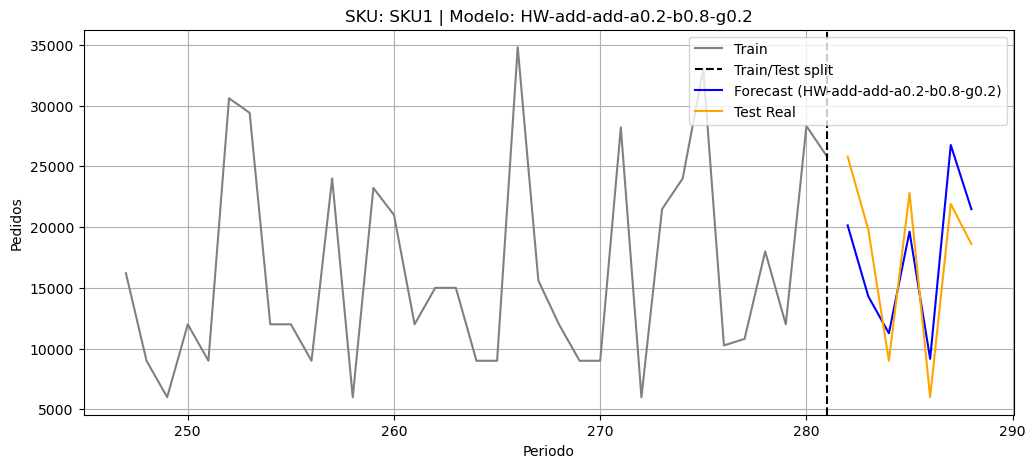

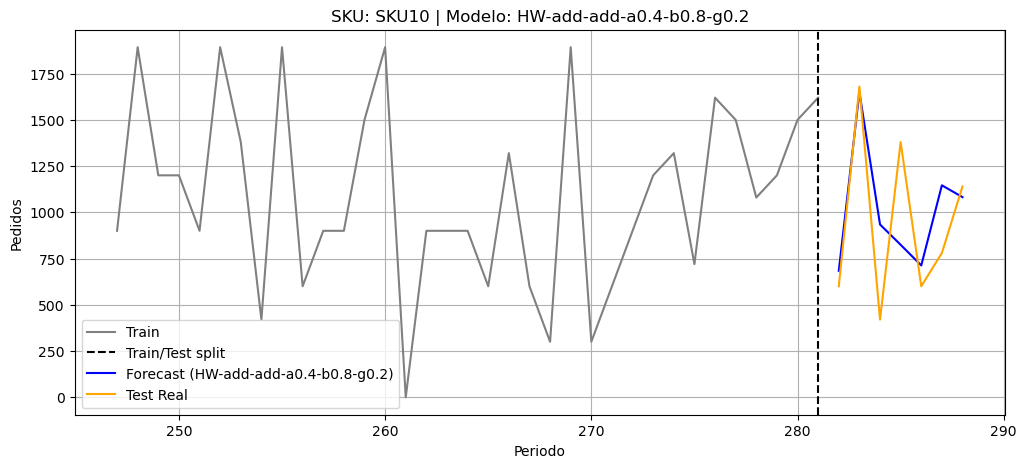

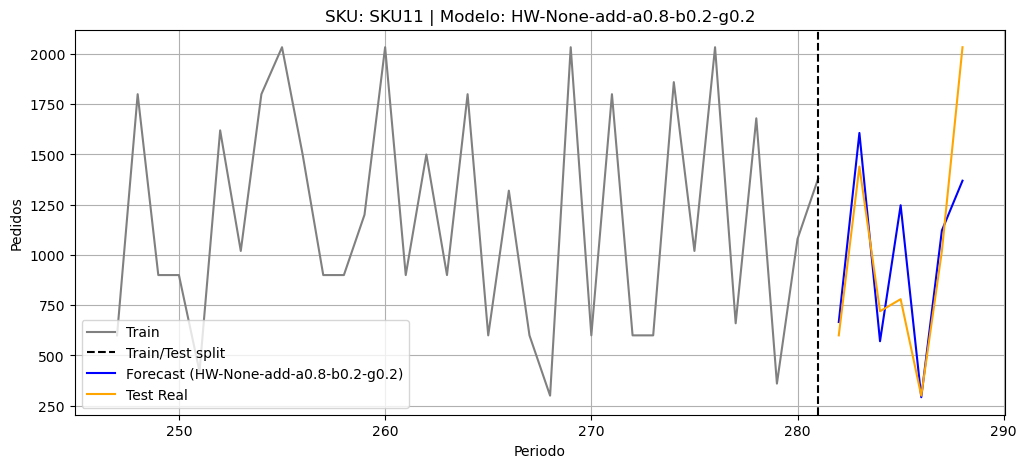

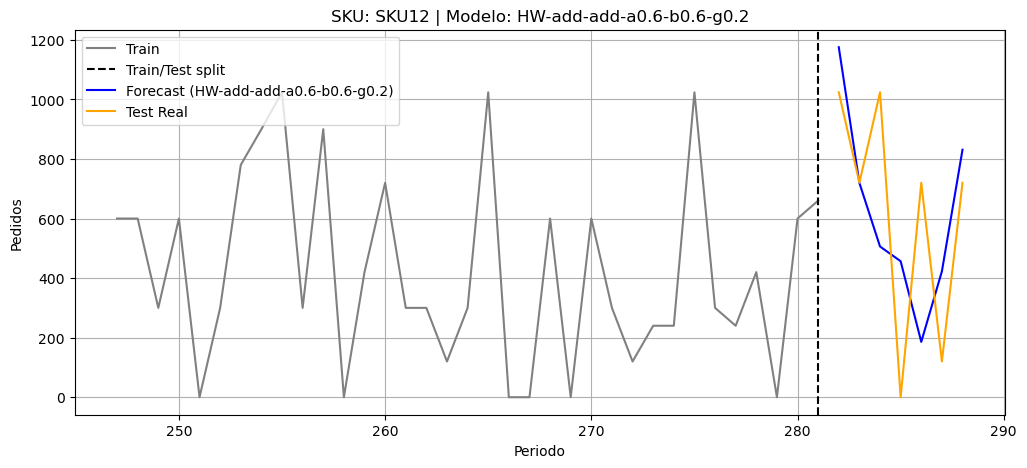

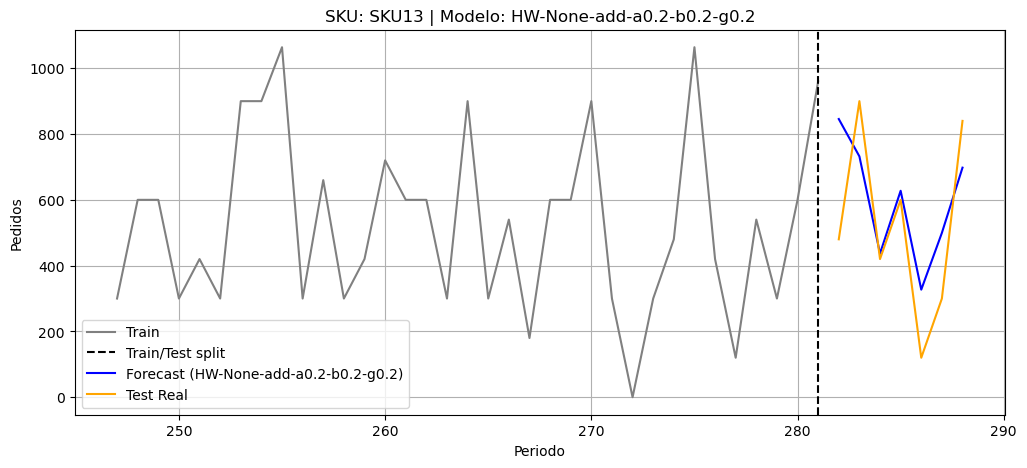

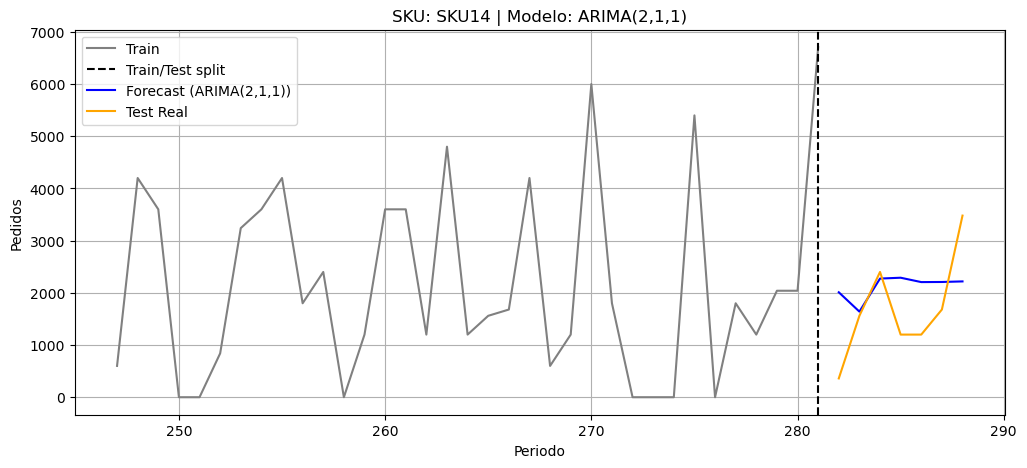

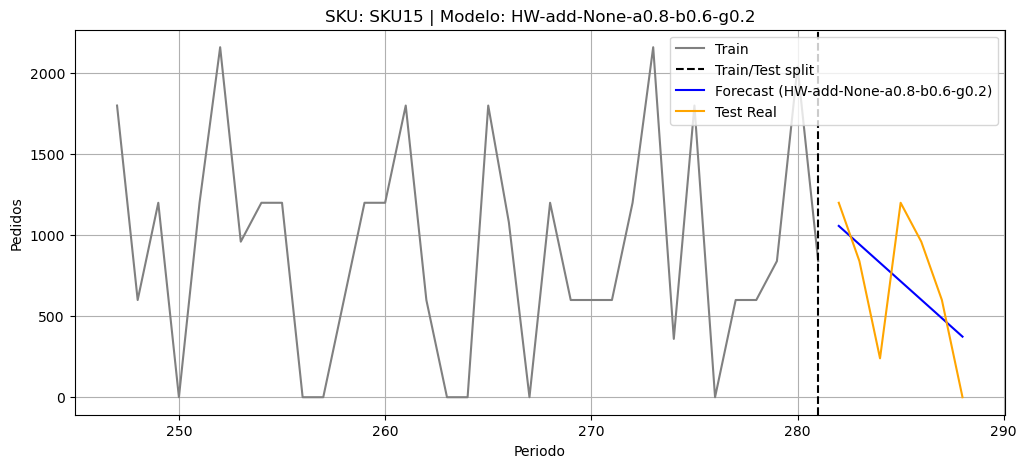

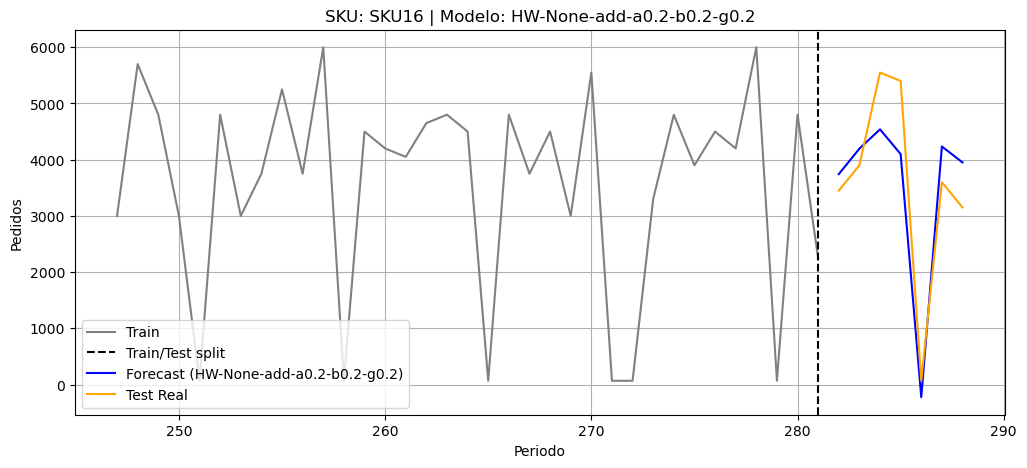

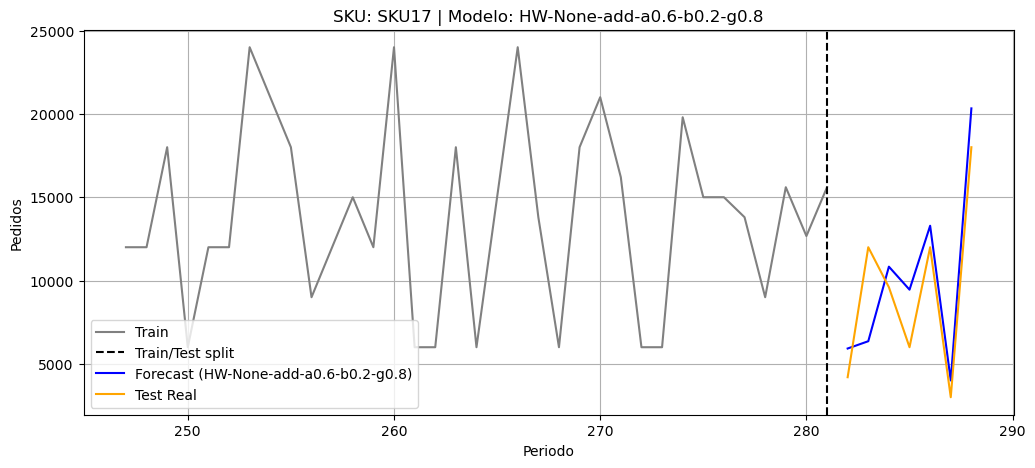

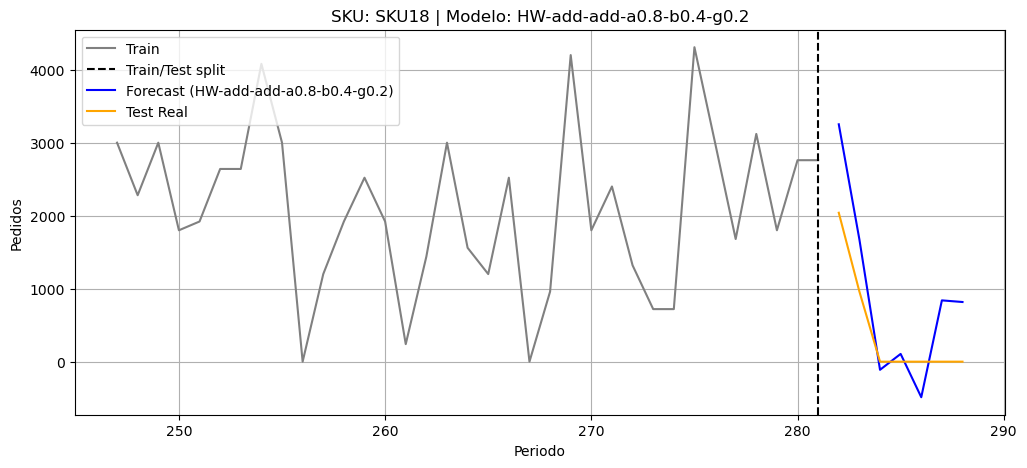

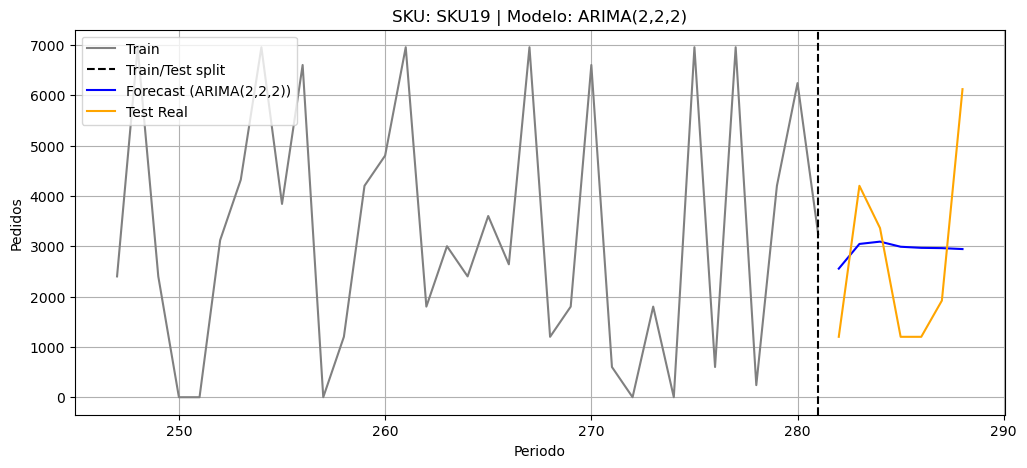

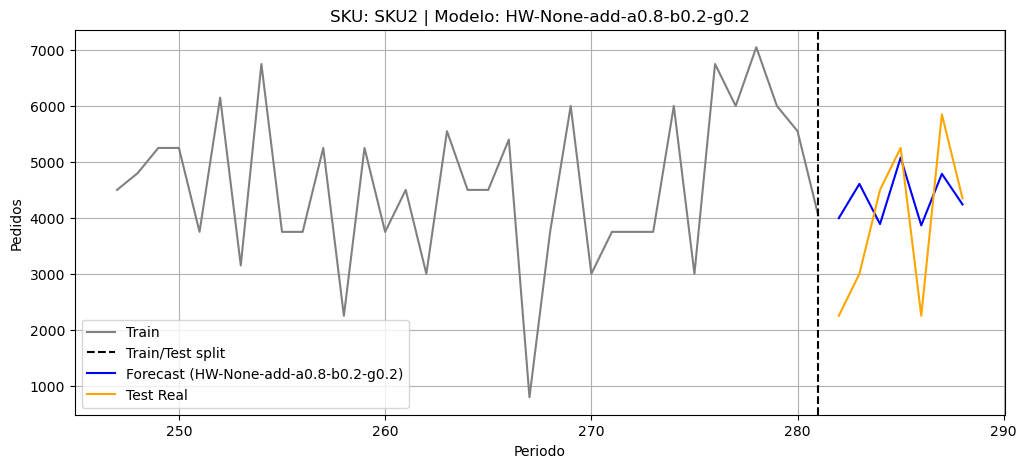

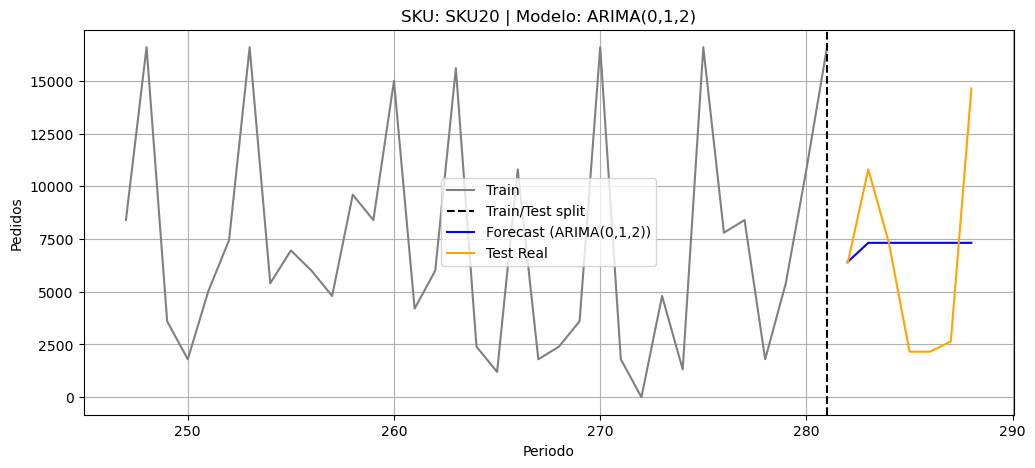

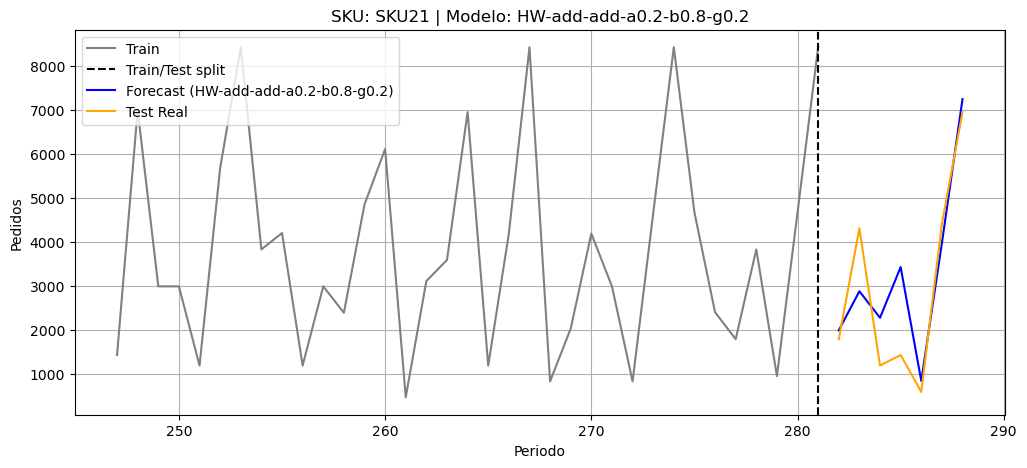

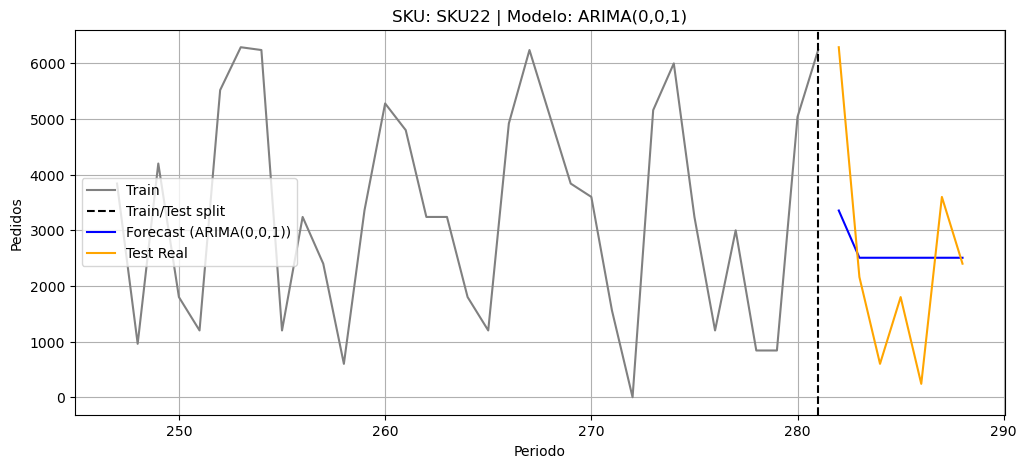

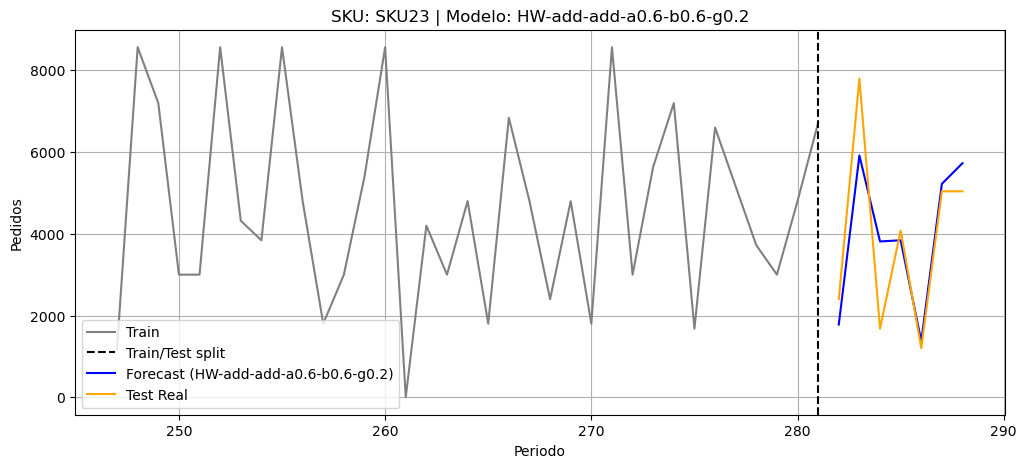

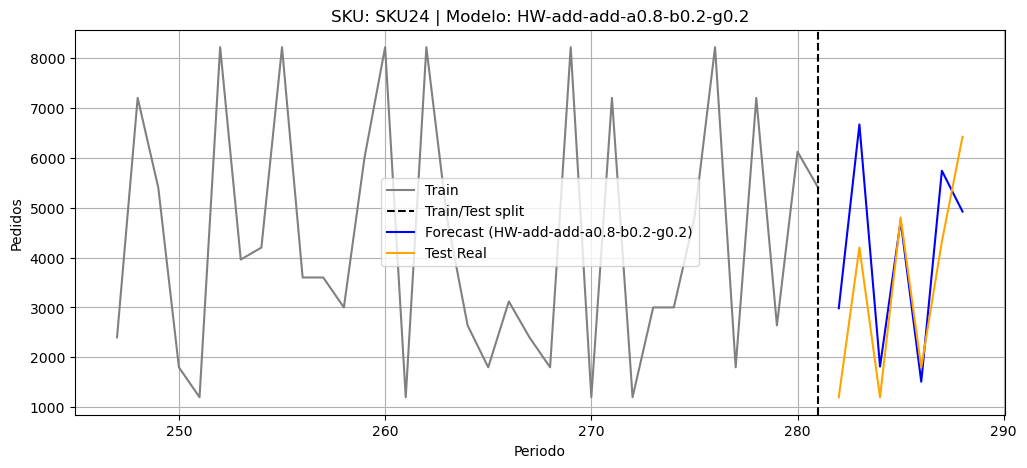

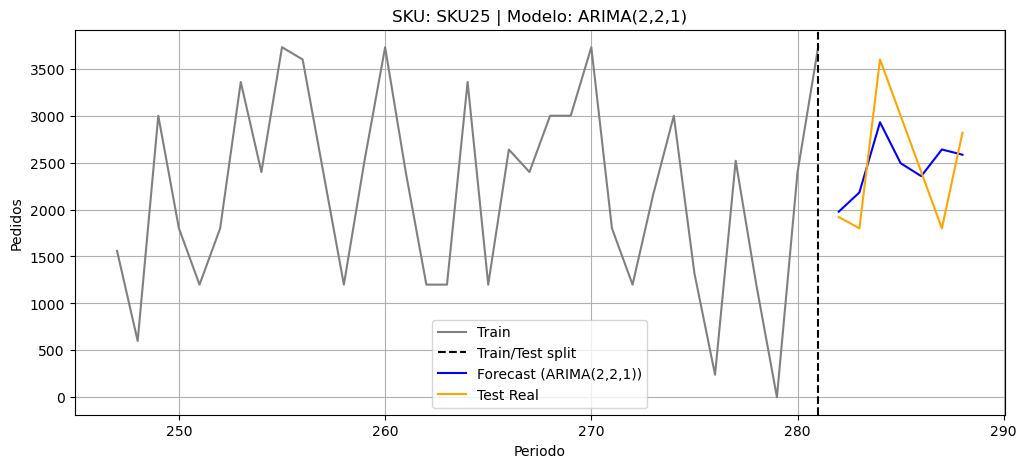

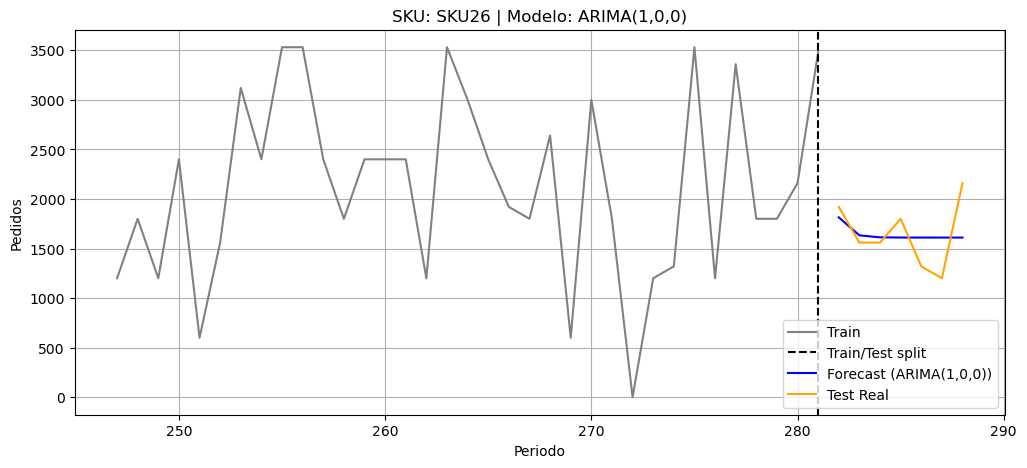

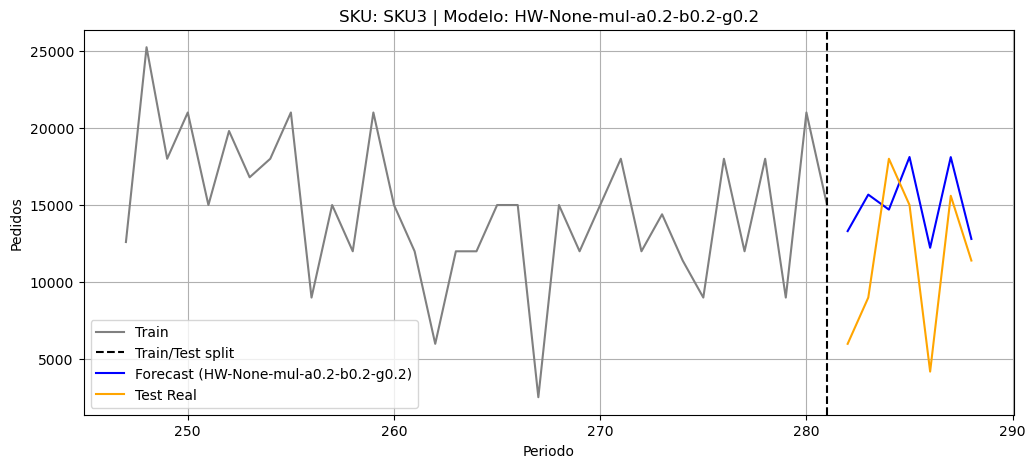

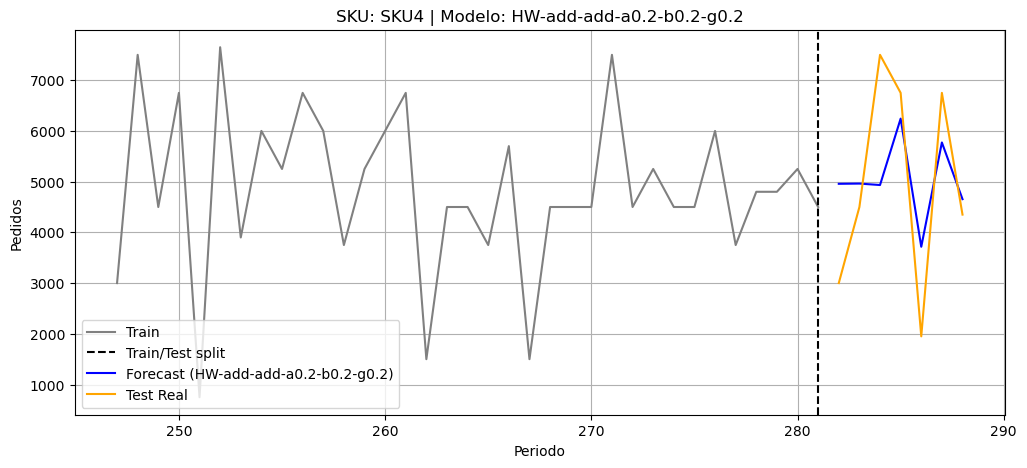

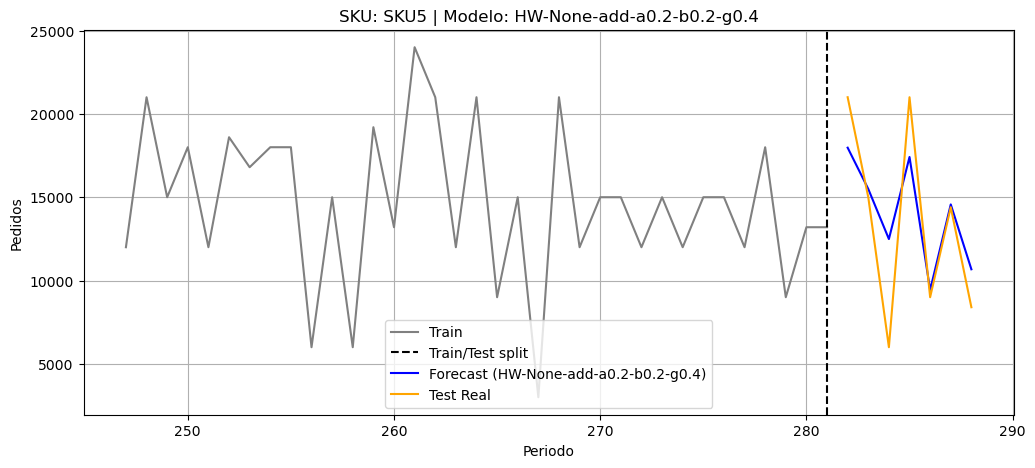

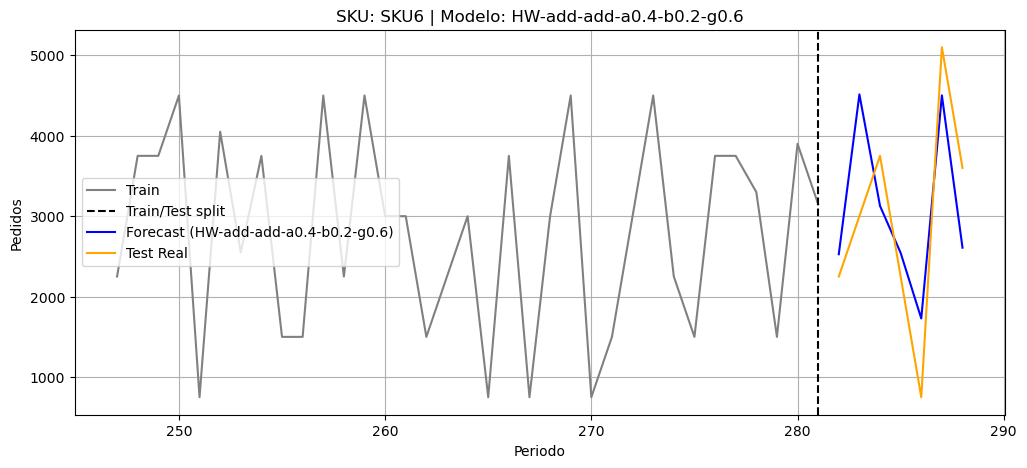

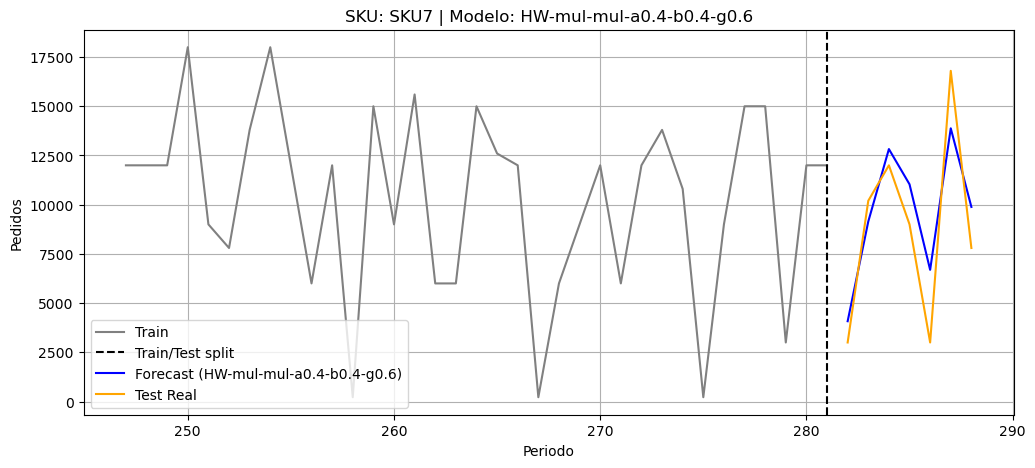

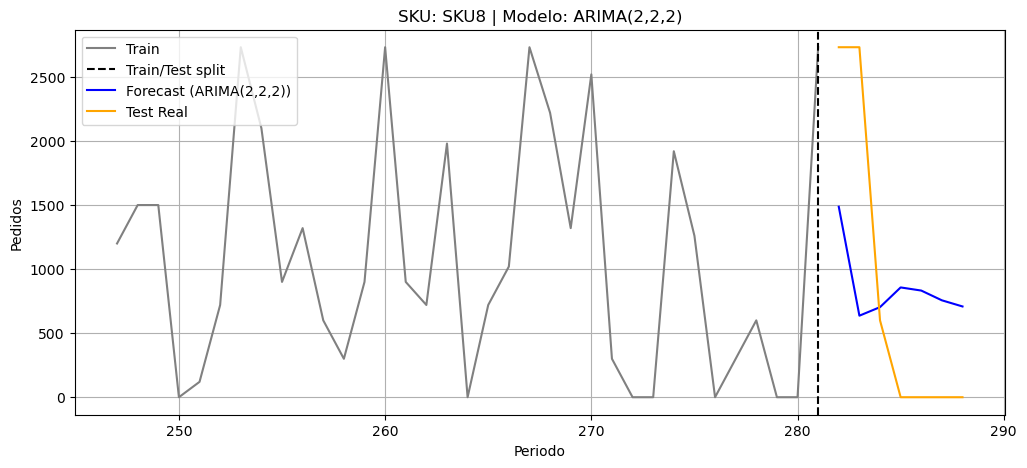

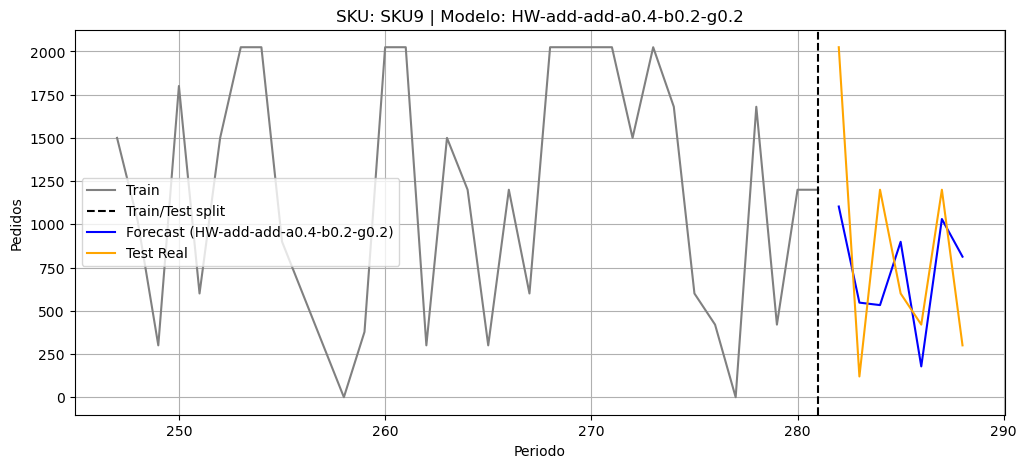

In [75]:
# Visualizar gráficas una por una con vista enfocada
for _, row in df_forecast_summary.iterrows():
    plot_forecast_focus(df_cleaned, row["SKU"], row)